In [1]:
###THIS NOTEBOOK SETS 

import pandas as pd
import os
import numpy as np
from datetime import datetime

from sklearn import linear_model, preprocessing
from sklearn.cluster import KMeans

from keras.models import Sequential
from keras.layers import Dense 
# fix random seed for reproducibility
np.random.seed(7)
path = os.getcwd()

data = pd.read_csv(path + '/GEFCOM/mod_data.csv')

Using TensorFlow backend.
/Users/charlesnatoli/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [670]:

### function assigns the day that in "data input" that is closest to the "day" provided. 
### this is used for find_all_similar_days_train and find_all_similar_days_test.
### similar here means the day with the lowest euclidean distance from the weather 
### at all 11 stations, the same month and hour, and a totDay that is within +- of 
### the "neighb" bumber
def assign_closest_day(data_input, day,neighb = 20) :  
    data_subset = data_input[data_input['totDay'] > day['totDay'] - neighb]
    data_subset = data_subset[data_subset['totDay'] < day['totDay'] + neighb]

    data_subset = data_subset[data_subset['month'] ==  day['month']]
    data_subset = data_subset[data_subset['hour'] ==  day['hour']]

    n_days = data_subset.shape[0]

    dists = np.zeros(n_days)

    d = (day[['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11']] - 
                data_subset[['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11']]) 
    dists = np.sum(d ** 2,axis = 1)
    
    match_day = np.argmin(dists)
   
    return(data_subset.loc[match_day]) 
    

In [671]:

## these two functions take a dataframe of loads, and add on the hours 
## that are the most similar using the function above. 
## for the "test" case it matches hours in the test set to  
## the most similar hour in the train set. 
def find_all_similar_days_train(input_data_zone) :

    similar_days = []
    input_data_zone.index = range(input_data_zone.shape[0])
    for i in range(input_data_zone.shape[0]) :
        similar_days.append(assign_closest_day(input_data_zone.drop(i),input_data_zone.iloc[i],10))

        if i % 2500 == 0:
            print(str(datetime.now()),i)

    similar_days_df = pd.DataFrame(similar_days)
    similar_days_df.index = range(similar_days_df.shape[0])
    colnames = similar_days_df.columns
    similar_days_df.columns = ([''] * (len(colnames)-12) +  ['similar'] * 12 ) + colnames 

    
    return(similar_days_df)


def find_all_similar_days_test(input_data_zone,test_data) :

    similar_days = []
    input_data_zone.index = range(input_data_zone.shape[0])
    for i in range(test_data.shape[0]) :
        similar_days.append(assign_closest_day(input_data_zone,test_data.iloc[i],100))

        if i % 2500 == 0:
            print(str(datetime.now()),i)

    similar_days_df = pd.DataFrame(similar_days)
    similar_days_df.index = range(similar_days_df.shape[0])
    colnames = similar_days_df.columns
    similar_days_df.columns = ([''] * (len(colnames)-12) +  ['similar'] * 12 ) + colnames 
    
    return(similar_days_df)


In [672]:

#### these functions create all features needed to train or test a neural net for 
#### a particular zone. It calls on the find_all_similar_days funtions above
def create_zonal_NN_features_test(data,test_data,zone,similar_days=False) : 
    
    input_data_zone = data[data['zone'] == zone]
    test_data_zone = test_data[test_data['zone'] == zone]
    if similar_days :
        similar_days_df = find_all_similar_days_test(input_data_zone,test_data_zone)  
        similar_days_df = similar_days_df.rename(index=str, 
                                                 columns={'zone':'zone.1',
                                                          'year': 'year.1',
                                                          'weekday': 'weekday.1'})
        similar_days_df.index = range(similar_days_df.shape[0])
    
    ##make dummies
    hour_dummies = pd.get_dummies(test_data_zone["hour"])
    hour_dummies.columns = hour_dummies.columns = pd.Series(hour_dummies.columns).apply(lambda x : 'hour_' + str(x))

    month_dummies = pd.get_dummies(pd.concat([test_data_zone["month"],pd.Series(range(1,13))]))
    month_dummies.columns = month_dummies.columns = pd.Series(month_dummies.columns).apply(lambda x : 'month_' + str(x))
    
    month_dummies = month_dummies.iloc[0:(month_dummies.shape[0]-12)] 
    
    
    print(test_data_zone.shape)
    print(hour_dummies.shape)
    print(month_dummies.shape)
    
    test_data_zone = pd.concat([test_data_zone,hour_dummies,month_dummies],  axis=1) 
    test_data_zone.index = range(test_data_zone.shape[0])
    print('#####\n\n\n')
    print(test_data_zone.shape)
    print(similar_days_df.shape)
    
    if similar_days : 
        test_data_zone = pd.concat([test_data_zone,similar_days_df],axis=1)
    
    print('#################\n test_data_zone \n\n',test_data_zone.columns)
    test_data_zone = test_data_zone.drop(['id','hour','day','month', 'totDay'],axis =1 )
    
    return(test_data_zone)

def create_zonal_NN_features_train(data,zone,similar_days=False) : 

    input_data_zone = data[data['zone'] == zone]
    if similar_days : 
        similar_days_df = find_all_similar_days_train(input_data_zone)
    
    ##make dummies
    hour_dummies = pd.get_dummies(input_data_zone["hour"])
    hour_dummies.columns = hour_dummies.columns = pd.Series(hour_dummies.columns).apply(lambda x : 'hour_' + str(x))

    month_dummies = pd.get_dummies(input_data_zone["month"])
    month_dummies.columns = month_dummies.columns = pd.Series(month_dummies.columns).apply(lambda x : 'month_' + str(x))

    input_data_zone = pd.concat([input_data_zone,hour_dummies,month_dummies],  axis=1)
    
    if similar_days :
        input_data_zone.index = range(len(input_data_zone)) 
        input_data_zone = pd.concat([input_data_zone,similar_days_df],axis=1)
    
    input_data_zone = input_data_zone.drop(['id','hour','day','month', 'totDay'],axis =1 )
    
    return(input_data_zone)
    
     
def train_zonal_NN(input_data_zone,zone,similar_days=False) :

    Y = np.array(input_data_zone['load'])
    Y = Y.reshape((Y.shape[0],1))
    X = np.array(input_data_zone.drop(['load','zone'],axis = 1)) 
    print(X.shape)
    X = X.reshape((X.shape[0],X.shape[1])) 
    print(X.shape)
    print(Y.shape)
    
    # create model
    model = Sequential()
    model.add(Dense(100, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu')) 
    model.add(Dense(1, activation='linear')) 
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    # Fit the model
    model.fit(X, Y, epochs=20, batch_size=10) 
    
    return(model,X,Y)
 

In [681]:
#### CREATE PROPERLY STRUCTURED TRAINING DATA AND TEST DATA FOR THE NNs
    
try :
    os.mkdir(path + '/NN_inputs')
except :
    pass

for zone in range(1,21) :
    input_data_zone = create_zonal_NN_features_train(data,zone,similar_days=True) 

    input_data_zone.to_csv(path + '/NN_inputs/similar_days_df_z'+str(zone)+'.csv') 


train_data = pd.read_csv(path + '/NN_inputs/similar_days_df_z1.csv')
train_data = train_data.drop(['Unnamed: 0'],axis = 1)

for zone in range(1,21) :

    test_data = pd.read_csv(path + '/GEFCOM/temp_for_solutions.csv')
    test_data = create_zonal_NN_features_test(data,test_data,zone,similar_days=True)
    test_data = test_data[train_data.columns]
    test_data.to_csv('/NN_inputs/test_data_z' + str(zone) + '.csv')

2017-12-01 22:40:54.414521 0
2017-12-01 22:41:13.316269 2500
2017-12-01 22:41:30.521731 5000
2017-12-01 22:41:47.037738 7500
2017-12-01 22:42:03.385290 10000
2017-12-01 22:42:18.345840 12500
2017-12-01 22:42:33.382360 15000
2017-12-01 22:42:48.833325 17500
2017-12-01 22:43:04.151931 20000
2017-12-01 22:43:21.212293 22500
2017-12-01 22:43:37.706100 25000
2017-12-01 22:43:54.467080 27500
2017-12-01 22:44:11.977597 30000
2017-12-01 22:44:29.214261 32500
2017-12-01 22:44:46.952518 35000
2017-12-01 22:45:03.757141 37500
2017-12-01 22:45:10.181920 0
2017-12-01 22:45:29.145469 2500
2017-12-01 22:45:49.117501 5000
2017-12-01 22:46:08.976980 7500
2017-12-01 22:46:28.006034 10000
2017-12-01 22:46:47.235952 12500
2017-12-01 22:47:06.487258 15000
2017-12-01 22:47:25.722712 17500
2017-12-01 22:47:45.272694 20000
2017-12-01 22:48:05.428414 22500
2017-12-01 22:48:23.719692 25000
2017-12-01 22:48:42.609928 27500
2017-12-01 22:48:58.678353 30000
2017-12-01 22:49:15.511635 32500
2017-12-01 22:49:31.6267

In [684]:
def make_XY_test(data) :
    Y = np.array(data['load'])
    Y = Y.reshape((Y.shape[0],1))
    X = np.array(data.drop(['load','zone'],axis = 1)) 
    print(X.shape)
    X = X.reshape((X.shape[0],X.shape[1])) 
    print(X.shape)
    print(Y.shape)
    return(X,Y)


models ={} ### each neural net model saved in this dictionary


## loop trains each neural net, tests it on the test set, and outputs the final product
for zone in range(1,21) :
    print(datetime.now())
    train_data = pd.read_csv(path + '/NN_inputs/similar_days_df_z'+str(zone)+'.csv') 
    
    model,X1,Y1 = train_zonal_NN(train_data,zone,similar_days=False)
    models[zone] = model 
    
    test_data = pd.read_csv(path + '/NN_inputs/test_data_z'+str(zone)+'.csv') 
    
    X,Y = make_XY_test(test_data) 
    
    pred = model.predict(X) 
    actual_series = pd.Series(np.reshape(Y,(Y.size,)))
    predicted_series = pd.Series(np.reshape(pred,(pred.size,)))
    predicted_df = pd.DataFrame({'predicted_NN':predicted_series,
                                'actual' : actual_series})
    predicted_df.index = range(predicted_df.shape[0])  

    d = pd.read_csv(path + '/GEFCOM/temp_for_solutions.csv')
    d = d[d['zone'] == zone]
    d.index = range(d.shape[0]) 

    df = pd.concat([d[['zone','year','month','day','hour']],predicted_df],axis=1) 
    
    df.to_csv(path + '/NN_inputs/predicted_results_z' + str(zone) + '.csv')


2017-12-01 23:43:42.211634
(38070, 65)
(38070, 65)
(38070, 1)
Epoch 1/20
38070/38070 [==============================] - 8s 222us/step - loss: 6469788.2401 - acc: 2.1014e-04
Epoch 2/20
38070/38070 [==============================] - 8s 214us/step - loss: 5556278.8562 - acc: 1.5760e-04
Epoch 3/20
38070/38070 [==============================] - 7s 193us/step - loss: 5472014.0754 - acc: 1.5760e-04
Epoch 4/20
38070/38070 [==============================] - 7s 196us/step - loss: 5454957.6254 - acc: 3.1521e-04
Epoch 5/20
38070/38070 [==============================] - 7s 191us/step - loss: 5389616.4969 - acc: 2.1014e-04
Epoch 6/20
38070/38070 [==============================] - 7s 192us/step - loss: 5364917.2552 - acc: 2.3641e-04
Epoch 7/20
38070/38070 [==============================] - 8s 211us/step - loss: 5337507.2065 - acc: 2.8894e-04
Epoch 8/20
38070/38070 [==============================] - 7s 190us/step - loss: 5311805.4168 - acc: 2.1014e-04
Epoch 9/20
38070/38070 [==========================

In [668]:
#### CALCULATE WRMSE FOR ALL THE RESULTS FILES 

running_num = 0 
running_denom = 0  
zone_21 = np.zeros(1344)

for zone in range(1,21) :
    zone_data = pd.read_csv(path + '/NN_inputs/predicted_results_z'+str(zone)+'.csv')
    diffs = zone_data['actual'] - zone_data['predicted_NN']
    diffs = np.array(diffs) 
    
    zone_21 +=diffs 
    
    diffs = np.reshape(diffs,(24,int(len(diffs)/24)))
    diffs = diffs[:,np.random.choice(56, 14)]
    diffs = diffs ** 2
    
    
    running_num +=  sum(sum(diffs))
    running_denom += 14*24 
    
    print(zone,(1000*sum(sum(diffs))/sum(zone_data['actual'] ** 2 ) ))

    
zone_21 = np.reshape(zone_21,(24,int(len(zone_21)/24)))
zone_21 = zone_21[:,np.random.choice(56, 14)]

zone_21 = zone_21 ** 2
zone_21 = zone_21 * 20
 
running_num += sum(sum(zone_21))
running_denom += 14*24*20

print((running_num/running_denom) ** 0.5) 


1 5.76814883281
2 3.32009763243
3 2.98930123372
4 4.77192039071
5 6.12735153461
6 3.02401827837
7 3.43402225206
8 3.17493982329
9 13.5636067342
10 4.83122012456
11 3.61784185422
12 5.35326878497
13 3.61493425171
14 7.85579721383
15 5.39470379528
16 6.14469980284
17 3.19064063237
18 5.66648269048
19 5.71119716111
20 2.94109260591
111541.414008


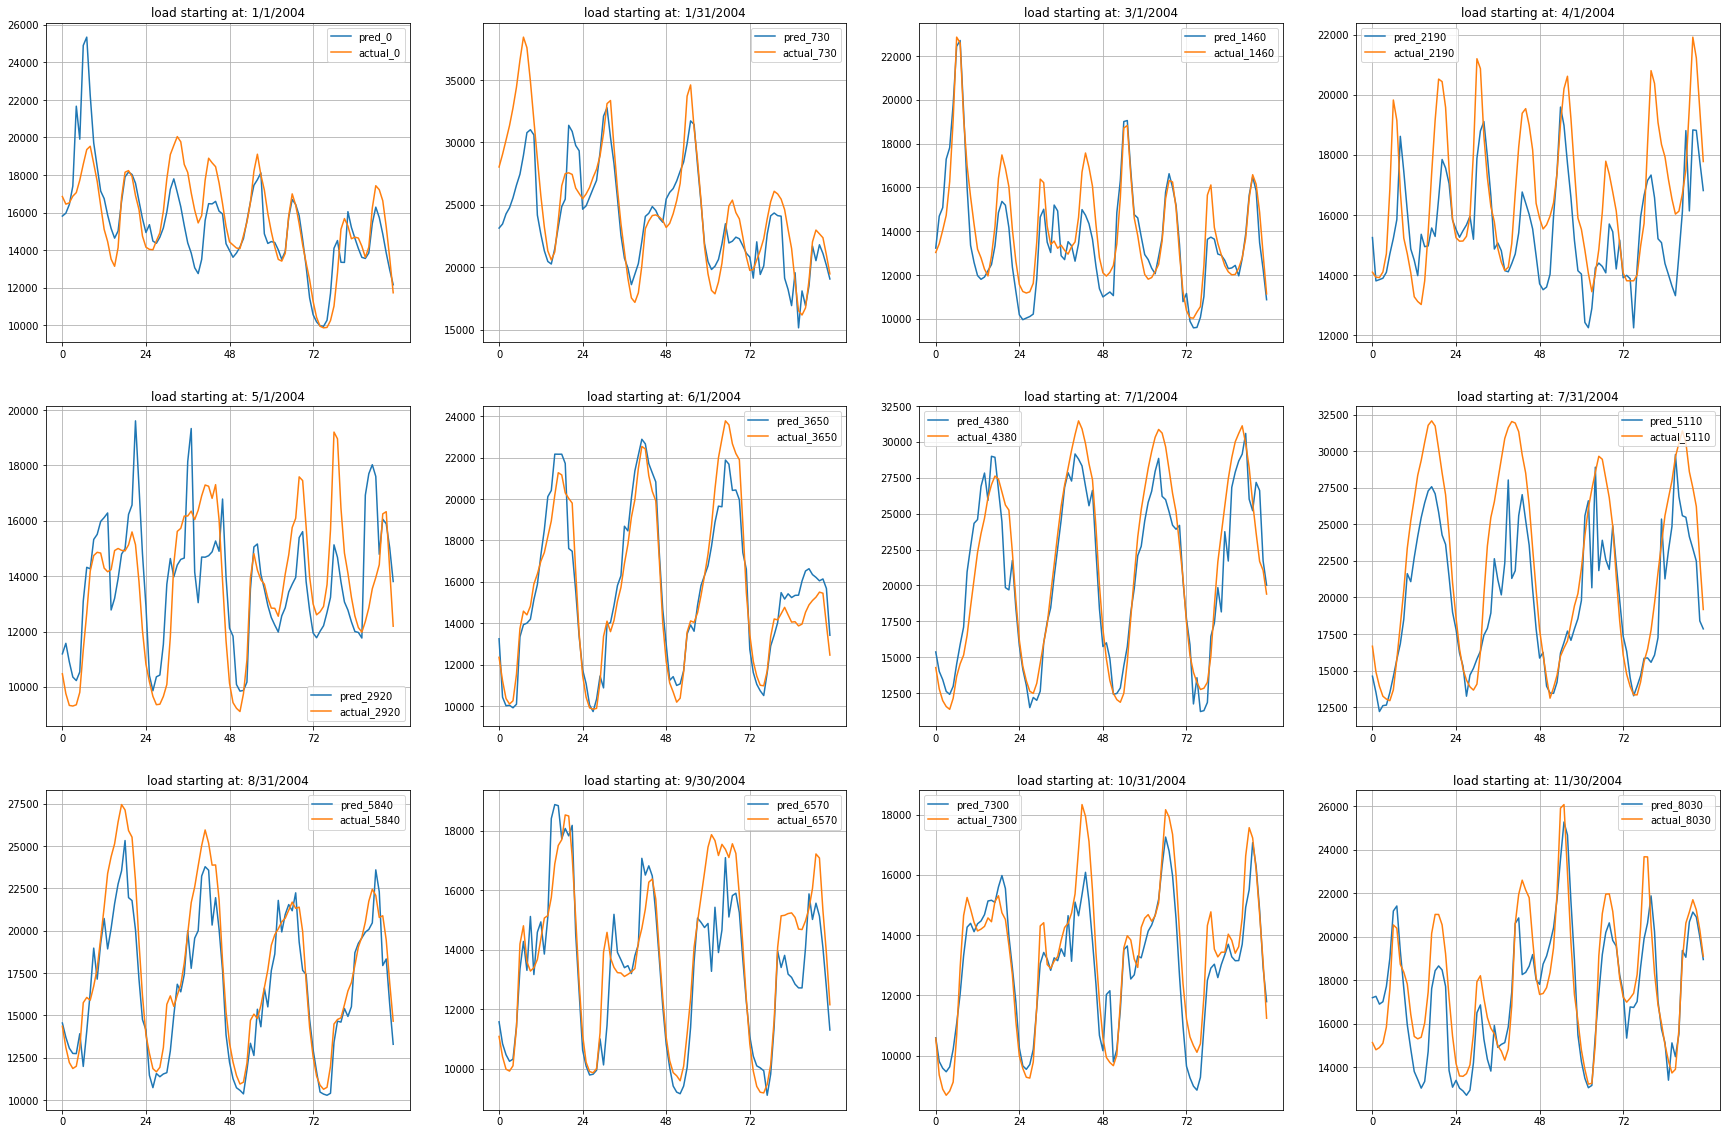

In [605]:
### train a NN and show results (maybe broken)

## in-sample predictions
gs = gridspec.GridSpec(3, 4)
fig = plt.figure(figsize = (30,20))

#make predictions
predictions = model.predict(X) 

#plot
num_days = 4
for plot_positon in range(12) :
    i = int(8760/12 * plot_positon)
    day = i - i % 24
    ax = fig.add_subplot(gs[int(plot_positon/4),plot_positon%4])
    plt.plot(predictions[day:(day+num_days*24)],label = "pred_" +  str(i))
    plt.plot(Y[day:(day+num_days*24)],label = "actual_" +  str(i))
    plt.xticks(np.arange(0, num_days*24, 24))
    d = data[data['zone']==1].iloc[i][['year','month','day']]
    plt.title('load starting at: '+ str(d['month']) + "/" + str(d['day']) + "/" + str(d['year']))
    plt.legend()
    plt.grid()
plt.show()  




In [679]:
input_data_zone

zone  year  weekday  w1  w2  w3  w4  w5  w6  w7     ...       \
0         1  2004        1  46  38  44  45  42  44  45     ...        
1         1  2004        1  46  36  42  43  42  43  44     ...        
2         1  2004        1  45  35  40  41  40  42  41     ...        
3         1  2004        1  41  30  36  37  39  38  40     ...        
4         1  2004        1  39  30  34  33  40  38  35     ...        
5         1  2004        1  35  29  32  32  41  37  35     ...        
6         1  2004        1  33  28  30  30  38  36  33     ...        
7         1  2004        1  33  28  30  29  33  36  30     ...        
8         1  2004        1  36  28  30  30  36  38  31     ...        
9         1  2004        1  47  33  32  41  43  44  39     ...        
10        1  2004        1  53  42  44  49  47  52  44     ...        
11        1  2004        1  54  47  49  54  50  55  51     ...        
12        1  2004        1  55  52  51  58  51  58  55     ...        
13        1  2004        1  55  54  52  59  51  60  56     ...        
14        1  2004        1  55  55  52  60  52  60  59     ...        
15        1  2004        1  55  56  52  60  51  60  60     ...        
16        1  2004        1  52  56  51  57  50  59  56     ...        
17        1  2004        1  46  52  48  51  47  53  51     ...        
18        1  2004        1  40  47  45  46  39  46  46     ...        
19        1  2004        1  40  46  35  43  39  44  42     ...        
20        1  2004        1  39  46  34  40  34  45  40     ...        
21        1  2004        1  38  45  30  37  33  43  38     ...        
22        1  2004        1  40  46  30  39  31  43  41     ...        
23        1  2004        1  41  46  30  42  33  45  41     ...        
24        1  2004        1  43  45  32  42  36  46  41     ...        
25        1  2004        1  44  44  33  44  36  47  42     ...        
26        1  2004        1  46  44  35  45  40  47  43     ...        
27        1  2004        1  46  45  39  45  42  46  45     ...        
28        1  2004        1  47  45  41  46  42  47  46     ...        
29        1  2004        1  47  44  42  46  43  45  46     ...        
...     ...   ...      ...  ..  ..  ..  ..  ..  ..  ..     ...        
38040     1  2008        0  82  66  77  83  78  76  86     ...        
38041     1  2008        0  82  67  75  82  76  76  77     ...        
38042     1  2008        0  85  67  75  81  75  75  76     ...        
38043     1  2008        0  83  66  75  80  76  75  75     ...        
38044     1  2008        0  83  66  75  79  75  75  73     ...        
38045     1  2008        0  81  66  75  79  76  74  73     ...        
38046     1  2008        0  83  66  75  80  77  74  75     ...        
38047     1  2008        0  83  69  79  81  81  77  77     ...        
38048     1  2008        0  83  73  82  83  83  80  80     ...        
38049     1  2008        0  87  76  83  87  86  83  84     ...        
38050     1  2008        0  89  77  85  89  86  85  84     ...        
38051     1  2008        0  91  77  85  90  90  86  87     ...        
38052     1  2008        0  92  78  85  91  89  87  89     ...        
38053     1  2008        0  92  77  87  94  88  86  88     ...        
38054     1  2008        0  93  78  88  94  90  88  87     ...        
38055     1  2008        0  93  80  89  94  89  89  88     ...        
38056     1  2008        0  94  77  88  95  90  86  88     ...        
38057     1  2008        0  91  76  87  95  88  84  88     ...        
38058     1  2008        0  91  74  87  92  88  79  86     ...        
38059     1  2008        0  88  73  84  89  86  73  85     ...        
38060     1  2008        0  85  68  83  79  83  72  79     ...        
38061     1  2008        0  84  67  79  75  82  72  77     ...        
38062     1  2008        0  76  67  79  71  79  71  75     ...        
38063     1  2008        0  74  67  76  71  75  71  75     ...        
38064     1  2008        1  74 